<a href="https://colab.research.google.com/github/temiyemi/visual-web-agent/blob/main/08.pyppeteer_roboflow_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Web Agent

A web agent to search for a product on Amazon.com, and add the product to cart.

Agent uses custom Langchain tools, Gemini 1.5 Flash, Pyppeteer, and a trained object detection model on Roboflow.

### Project Setup

Install required dependencies

In [1]:
!pip install -q pyppeteer

In [2]:
!pip install -q roboflow

In [3]:
!pip install -q inference

In [4]:
!pip install -q langchain

In [5]:
!pip install -q google-generativeai langchain-google-genai

In [6]:
import asyncio
import json
import os
import uuid

In [7]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
ROBOFLOW_WORKSPACE = userdata.get("ROBOFLOW_WORKSPACE")
MODEL_ENDPOINT = userdata.get("MODEL_ENDPOINT")
MODEL_VERSION = userdata.get("MODEL_VERSION")

In [8]:
HOME = os.getcwd()
print(HOME)

try:
  os.mkdir(path=f"{HOME}/screenshots") # for screenshots by pyppeteer
  os.mkdir(path=f"{HOME}/predictions") # for annotated images from roboflow model
except:
  print("screenshots/predictions folders already exist")
  pass

/content
screenshots/predictions folders already exist


### Object Detection Model Section

In [9]:
from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace(ROBOFLOW_WORKSPACE).project(MODEL_ENDPOINT)
rbf_model = project.version(MODEL_VERSION).model

loading Roboflow workspace...
loading Roboflow project...


In [10]:
import supervision as sv
from inference import get_model

MODEL_ID = f"{MODEL_ENDPOINT}/{MODEL_VERSION}"

inf_model = get_model(model_id=MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [11]:
def make_inference(image: str, label: str, confidence: int = 40, overlap: int = 30) -> list[dict]:
    """Use inference model and supervision for object detection and return list of coordinates"""

    results = inf_model.infer(
        image=image,
        class_filter=[label],
        confidence=confidence/100,
        iou_threshold = overlap/100
    )[0]
    detections = sv.Detections.from_inference(results)
    keys = ['x1', 'y1', 'x2', 'y2']
    coordinates = [{ keys: values for keys, values in zip(keys, values) } for values in detections.xyxy]
    return coordinates

In [12]:
def make_prediction(image: str, label: str, confidence: int = 40, overlap: int = 30) -> list[dict]:
    """Use roboflow model to predict label(s) in the image and return list of coordinates"""

    resp = rbf_model.predict(image, classes=label, confidence=confidence, overlap=overlap)
    new_filepath = image.replace('screenshots', 'predictions')
    resp.save(new_filepath) # save the annotated image file
    predictions = resp.json()['predictions']
    if label:
        predictions = list(filter(lambda x: x['class'] == label, predictions))

    attrs = ['x', 'y', 'width', 'height']
    coordinates = [{k:v for (k,v) in pred.items() if k in attrs} for pred in predictions]
    return coordinates

In [13]:
def predict_boundaries(image: str, label: str, confidence: int = 40, overlap: int = 30) -> list[dict]:
    """Make inference/prediction for label(s) in the image and return the coordinates"""

    # return make_prediction(image, label, confidence, overlap)
    return make_inference(image, label, confidence, overlap)


def get_bounding_boxes(predictions: list[dict]) -> list[tuple]:
    """Calculate and set the top-left and bottom-right coordinates"""

    def get_bounding_box(prediction: dict) -> dict:
        prediction['x1'] = prediction['x'] - prediction['width'] / 2
        prediction['y1'] = prediction['y'] - prediction['height'] / 2
        prediction['x2'] = prediction['x'] + prediction['width'] / 2
        prediction['y2'] = prediction['y'] + prediction['height'] / 2
        return prediction

    return list(map(get_bounding_box, predictions))


def get_center(coordinate: dict) -> tuple:
    """Calculate and retrun the midpoint coordinate of the bounding box"""

    x = coordinate['x1'] + (coordinate['x2'] - coordinate['x1']) / 2
    y = coordinate['y1'] + (coordinate['y2'] - coordinate['y1']) / 2
    return x, y

### Pyppeteer Section

In [40]:
from pyppeteer import launch, connect

async def click_on(page, coordinate: dict) -> None:
    """Click on the x,y coordinate of the page"""

    x, y = get_center(coordinate=coordinate)

    await page.mouse.move(x, y)
    await page.mouse.click(x, y)

async def click_wait(page, coordinate: dict) -> None:
    """Click on the x,y coordinate of the page and wait for navigation"""

    x, y = get_center(coordinate=coordinate)

    await asyncio.gather(
        # page.mouse.move(x, y),
        page.mouse.click(x, y),
        page.waitForNavigation(waitUntil='networkidle2'),
    )

async def fill_and_submit(page, product_name: str) -> None:
    """Fill product name in the searchbar and submit form"""

    await page.keyboard.type(product_name, options={'delay': 100})
    await page.keyboard.press('Enter')
    await page.waitForNavigation(waitUntil='networkidle2')


async def save_screenshot(page) -> str:
    """Save the screenshot of the page with a unique file name"""

    filename = str(uuid.uuid4())
    filepath = f"{HOME}/screenshots/{filename}.png"
    await page.screenshot(path=filepath)
    return filepath


async def get_browser_connection_url() -> str:
    """Launch the browser instance and only return the websocket endpoint"""

    browser = await launch(
        ignoreHTTPSErrors=True,
        headless=True,
        args=[
            "--no-sandbox",
            "--disable-setuid-sandbox",
            "--disable-gpu",
            "--disable-dev-shm-usage",
            '--proxy-server="direct://"',
            "--proxy-bypass-list=*"
        ],
        autoClose=False
    )

    ws_endpoint = browser.wsEndpoint
    await browser.disconnect()
    return ws_endpoint


async def get_active_browser_and_page(ws_endpoint: str) -> tuple:
    """Reconnect to existing browser using the websocket endpoint, and
    return the browser instance, and the current active page"""

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    for page in (await browser.pages()):
        await page.bringToFront()
        print(await page.title())

    return browser, page

In [15]:
async def browser_phase_one(product: str) -> tuple:
    """
    Open amazon.com, take a screenshot, make searchbar coordinates inference,
    click on the searchbar coordinate and type in the product name then press submit,
    wait for the search results page to load, take another screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    ws_endpoint = await get_browser_connection_url()

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    page = await browser.newPage()

    # Go to amazon.com homepage
    await page.goto(
        url='https://www.amazon.com',
        options={
            'waitUntil': 'networkidle2',
        }
    )

    screenshot = await save_screenshot(page)

    # make searchbar inference on the screenshot
    coordinates = predict_boundaries(image=screenshot, label='searchbar')

    # the searchbar is always coordinates[0]
    await click_on(page, coordinate=coordinates[0])

    await fill_and_submit(page, product_name=product)

    screenshot = await save_screenshot(page)

    await browser.disconnect()

    return ws_endpoint, screenshot

In [16]:
# Uncomment to test browser_phase_one function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_one(product="braun hair trimmers"), loop)
# future.result()

In [17]:
async def browser_phase_two(ws_endpoint: str, coordinate: dict) -> str:
    """
    Re-connect to the browser, and using the existing page, click on the product's
    coordinate and wait for the product detail page to load, then take a screenshot.

    Return screenshot.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_wait(page, coordinate=coordinate)

    # scroll page down a bit, in case add to cart button is not in viewport
    await page.evaluate('window.scroll(0, 300)')

    screenshot = await save_screenshot(page)
    # for inference of the add to cart button

    await browser.disconnect()

    return screenshot

In [18]:
# Uncomment to test browser_phase_two function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_two(ws_endpoint=""), loop)
# future.result()

In [19]:
async def browser_phase_three(ws_endpoint: str, coordinate: dict) -> str:
    """
    Re-connect to the browser, and using the existing page, click on the add to cart
    button coordinate and wait for the next page to load, then take a screenshot.

    Return screenshot.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_wait(page, coordinate=coordinate)

    screenshot = await save_screenshot(page)
    # for inference of the "Go to Cart" button

    await browser.disconnect()

    return screenshot

In [20]:
# Uncomment to test browser_phase_three function in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_three(ws_endpoint="", coordinate), loop)
# future.result()

In [21]:
async def browser_phase_four(ws_endpoint: str, coordinate: dict) -> str:
    """
    Re-connect to the browser, and using the existing page, click on the "Go to Cart"
    button coordinate and wait for the next page to load, then take a screenshot.

    Return screenshot.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_wait(page, coordinate=coordinate)

    screenshot = await save_screenshot(page)

    await browser.disconnect()
    # or consider closing the browser here finally
    # Job is done!

    return screenshot

### Langchain Tools / Functions

In [22]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool

from IPython.display import Image

json_parser = JsonOutputParser()

In [23]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    google_api_key=GOOGLE_API_KEY,
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE
    },
)

In [24]:
async def product_search_function(product: str) -> tuple:
    """use pyppeteer to browse Amazon.com and search for product"""

    ws_endpoint, screenshot = await browser_phase_one(product=product)
    return ws_endpoint, screenshot

product_search_tool = StructuredTool.from_function(
    coroutine=product_search_function,
    name="ProductSearch",
    description="use this function to search for a product on Amazon.com",
    handle_tool_error=True,
)

ws://127.0.0.1:57467/devtools/browser/bb44f887-8767-45ed-bab4-3ed687f52536
/content/screenshots/4bcc4b00-87c7-44e6-9076-87e119bd8ae3.png


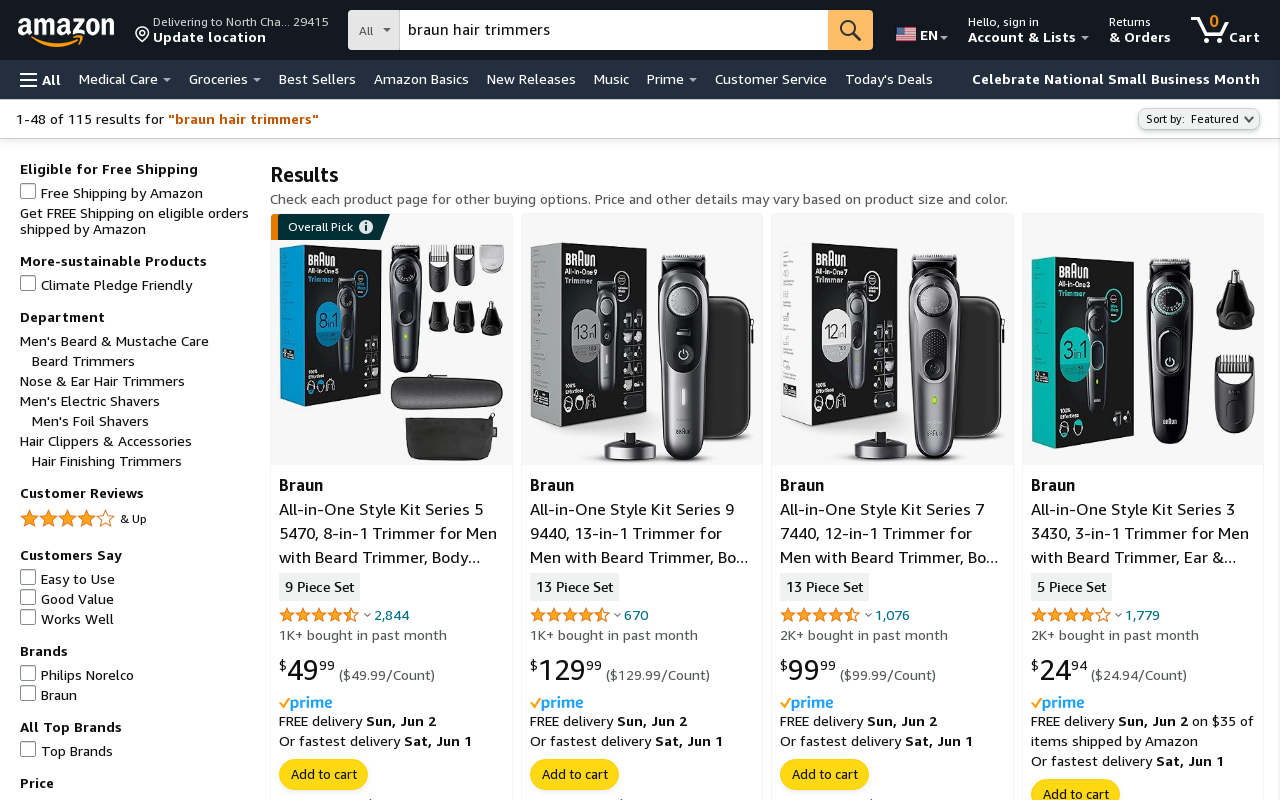

In [25]:
# Test product_search_tool
ws_endpoint, screenshot = await product_search_tool.ainvoke({"product": "braun hair trimmers"})

print(ws_endpoint, screenshot, sep="\n")

Image(screenshot)

In [26]:
def identify_products_function(screenshot: str) -> list[dict]:
    """use vlm to read the screenshot and prompt gemini to list the product on
    the page, and their corresponding coordinates."""

    # make product links inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='productlink',
        # confidence=5,
        # overlap=5
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of product listings on Amazon.com.
                  Note the products featured in this image, their prices, and the order in
                  which they appear from left to right.""",
            },
            {
                "type": "text",
                "text": """The origin (0,0) of the coordinate system is the top-left
                  corner of the entire image. Given the following array of bounding box
                  coordinates objects with keys x1, y1, x2, y2 where (x1, y1) is the coordinate
                  for the top-left corner, and (x2, y2) is the coordinate for the
                  bottom-right corner of the bounding box around each product shown in
                  the image.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object, containing the name, price,
                   x1, y1, x2, and y2 of the products in the image. Use the
                   coordinates values given in the array."""
            }

        ]
    )

    resp = llm.invoke([message])

    return json_parser.parse(resp.content)


identify_products_tool = StructuredTool.from_function(
    func=identify_products_function,
    name="IdentifyProducts",
    description="""use this function to identify and get the list of products
       featured in the screenshot and their coordinates""",
    handle_tool_error=True,
)

In [27]:
# Test identify_products_tool
products = identify_products_tool.invoke({"screenshot": screenshot})
products

[{'name': 'Braun All-in-One Style Kit Series 5 5470, 8-in-1 Trimmer for Men with Beard Trimmer, Body...',
  'price': '$4999',
  'x1': 213,
  'y1': 613,
  'x2': 391,
  'y2': 955},
 {'name': 'Braun All-in-One Style Kit Series 9 9440, 13-in-1 Trimmer for Men with Beard Trimmer, Bo...',
  'price': '$12999',
  'x1': 432,
  'y1': 613,
  'x2': 610,
  'y2': 955},
 {'name': 'Braun All-in-One Style Kit Series 7 7440, 12-in-1 Trimmer for Men with Beard Trimmer, Bo...',
  'price': '$9999',
  'x1': 651,
  'y1': 613,
  'x2': 829,
  'y2': 955},
 {'name': 'Braun All-in-One Style Kit Series 3 3430, 3-in-1 Trimmer for Men with Beard Trimmer, Ear &...',
  'price': '$2494',
  'x1': 870,
  'y1': 613,
  'x2': 999,
  'y2': 955}]

In [28]:
async def select_product_function(ws_endpoint: str, coordinate: dict) -> str:
    """use pyppeteer to locate and click the product link on Amazon"""

    screenshot = await browser_phase_two(ws_endpoint, coordinate)
    return screenshot

select_product_tool = StructuredTool.from_function(
    coroutine=select_product_function,
    name="SelectProduct",
    description="use this function to click the product link on Amazon.com",
    handle_tool_error=True,
)

In [29]:
"""TODO:
Interact with user via prompting and make the user select his choice
of product to select from the options returned from the tool above.
In the mean time...
"""
# select the first product in the list for the user
products[1]

{'name': 'Braun All-in-One Style Kit Series 9 9440, 13-in-1 Trimmer for Men with Beard Trimmer, Bo...',
 'price': '$12999',
 'x1': 432,
 'y1': 613,
 'x2': 610,
 'y2': 955}

In [41]:
# Test select_product_tool
screenshot = await select_product_tool.ainvoke({
    "ws_endpoint": ws_endpoint,
    "coordinate": products[1]
})

print(screenshot)

Image(screenshot)


Amazon.com : braun hair trimmers


TimeoutError: Navigation Timeout Exceeded: 30000 ms exceeded.

In [31]:
def identify_add_to_cart_function(screenshot: str) -> dict:
    """use vlm to read the screenshot and prompt gemini to identify the
    coordinates of the "Add to Cart" button on the page."""

    # make button inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='button'
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of a product page on Amazon.com.
                  Note the buttons on this page that a user can interact with in
                  in order to buy the product.""",
            },
            {
                "type": "text",
                "text": """The origin (0,0) of the coordinate system is the top-left
                   corner of the entire image. Given the following array of objects
                   with keys, x1, y1, x2, y2 where (x1, y1) is the coordinate
                   for the top-left corner, (x2, y2) is the coordinate of the bottom-right
                   corner of the bounding box around the buttons in the image.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object containing the x1, y1, x2, y2
                    coordinates of the bounding box around the "Add to Cart"
                    button in the image. There is only one "Add to Cart" button
                    so the expected JSON should one object."""
            }

        ]
    )

    resp = llm.invoke([message])

    resp_json = json_parser.parse(resp.content)

    if isinstance(resp_json, list):
        return resp_json[0]

    return resp_json


identify_add_to_cart_tool = StructuredTool.from_function(
    func=identify_add_to_cart_function,
    name="IdentifyAddToCart",
    description="""use this function to identify the Add to Cart button in the
    screenshot and its coordinate""",
    handle_tool_error=True,
)

In [32]:
# Test identify_add_to_cart_tool
coordinate = identify_add_to_cart_tool.invoke({"screenshot": screenshot})

coordinate

{'x1': 278, 'y1': 759, 'x2': 367, 'y2': 792}

In [33]:
async def add_product_to_cart_function(ws_endpoint: str, coordinate: dict) -> str:
    """use pyppeteer to locate and click the "Add to Cart" button on Amazon"""

    screenshot = await browser_phase_three(ws_endpoint, coordinate)
    return screenshot

add_product_to_cart_tool = StructuredTool.from_function(
    coroutine=add_product_to_cart_function,
    name="AddProductToCart",
    description="use this function to click the Add to Cart button for the product",
    handle_tool_error=True,
)

In [34]:
# Test add_product_to_cart_tool
screenshot = await add_product_to_cart_tool.ainvoke({
    "ws_endpoint": ws_endpoint,
    "coordinate": coordinate
})

print(screenshot)

Image(screenshot)


Amazon.com : braun hair trimmers


TimeoutError: Navigation Timeout Exceeded: 30000 ms exceeded.

In [35]:
def identify_go_to_cart_function(screenshot: str) -> dict:
    """use vlm to read the screenshot and prompt gemini to identify the
    coordinates of the "Go to Cart" button on the page."""

    # Make button inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='button'
    )

    coordinates_str = json.dumps(coordinates)

    message = HumanMessage(
    content = [
            {
                "type": "image_url",
                "image_url": screenshot
            },
            {
                "type": "text",
                "text": """This is a screenshot of a page after a product
                  has been added to cart on Amazon.com.
                  Note the buttons on this page that a user can interact with
                  in order to buy the product.""",
            },
            {
                "type": "text",
                "text": """The origin (0,0) of the coordinate system is the
                   top-left corner of the entire image. Given the following
                   array of objects with keys, x1, y1, x2, y2 where (x1, y1) is the
                   coordinate of the top-left corner, (x2, y2) is the coordinate for
                   the bottom-right corner of the bounding box around the buttons
                   in the image.""",
            },
            {
                "type": "text",
                "text": coordinates_str
            },
            {
                "type": "text",
                "text": """Return a JSON object containing the x1, y1, x2, y2
                    coordinates of the bounding box around the "Proceed to Checkout"
                    button in the image. There is only one "Proceed to Checkout" button
                    so the expected JSON should be one object."""
            }

        ]
    )

    resp = llm.invoke([message])

    resp_json = json_parser.parse(resp.content)

    if isinstance(resp_json, list):
        return resp_json[0]

    return resp_json


identify_go_to_cart_tool = StructuredTool.from_function(
    func=identify_go_to_cart_function,
    name="IdentifyGoToCart",
    description="""use this function to identify the "Go to Cart" button in the
    screenshot and its coordinate""",
    handle_tool_error=True,
)

In [36]:
# Test identify_go_to_cart tool
coordinate = identify_go_to_cart_tool.invoke({"screenshot": screenshot})

coordinate

{'x1': 1029.0, 'y1': 779.0, 'x2': 1123.0, 'y2': 800.0}

In [37]:
async def go_to_cart_function(ws_endpoint: str, coordinate: dict) -> str:
    """use pyppeteer to locate and click the "Go to Cart" button on Amazon"""

    screenshot = await browser_phase_four(ws_endpoint, coordinate)
    return screenshot

go_to_cart_tool = StructuredTool.from_function(
    coroutine=go_to_cart_function,
    name="GoToCart",
    description="""use this function to click the Go to Cart button and view
      the shopping cart on Amazon""",
    handle_tool_error=True,
)

In [38]:
# Test go_to_cart_tool
screenshot = await go_to_cart_tool.ainvoke({
    "ws_endpoint": ws_endpoint,
    "coordinate": coordinate
})

print(screenshot)

Image(screenshot)


Amazon.com : braun hair trimmers


TimeoutError: Navigation Timeout Exceeded: 30000 ms exceeded.